In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import datetime
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from prophet import Prophet

from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
...,...,...,...,...,...,...
136945,136945,2021-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,700
136946,136946,2021-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,752
136947,136947,2021-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,111
136948,136948,2021-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,641


In [4]:
df['date'] = df['date'].astype('datetime64')

In [5]:
df['date']

0        2017-01-01
1        2017-01-01
2        2017-01-01
3        2017-01-01
4        2017-01-01
            ...    
136945   2021-12-31
136946   2021-12-31
136947   2021-12-31
136948   2021-12-31
136949   2021-12-31
Name: date, Length: 136950, dtype: datetime64[ns]

In [6]:
df['year'] = df.date.dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.dayofweek

In [7]:
np.round(pd.pivot_table(data=df, index=['country', 'store'], columns='product',
                        values = 'num_sold'), 2).style.background_gradient('autumn_r')

<Axes: xlabel='country', ylabel='num_sold'>

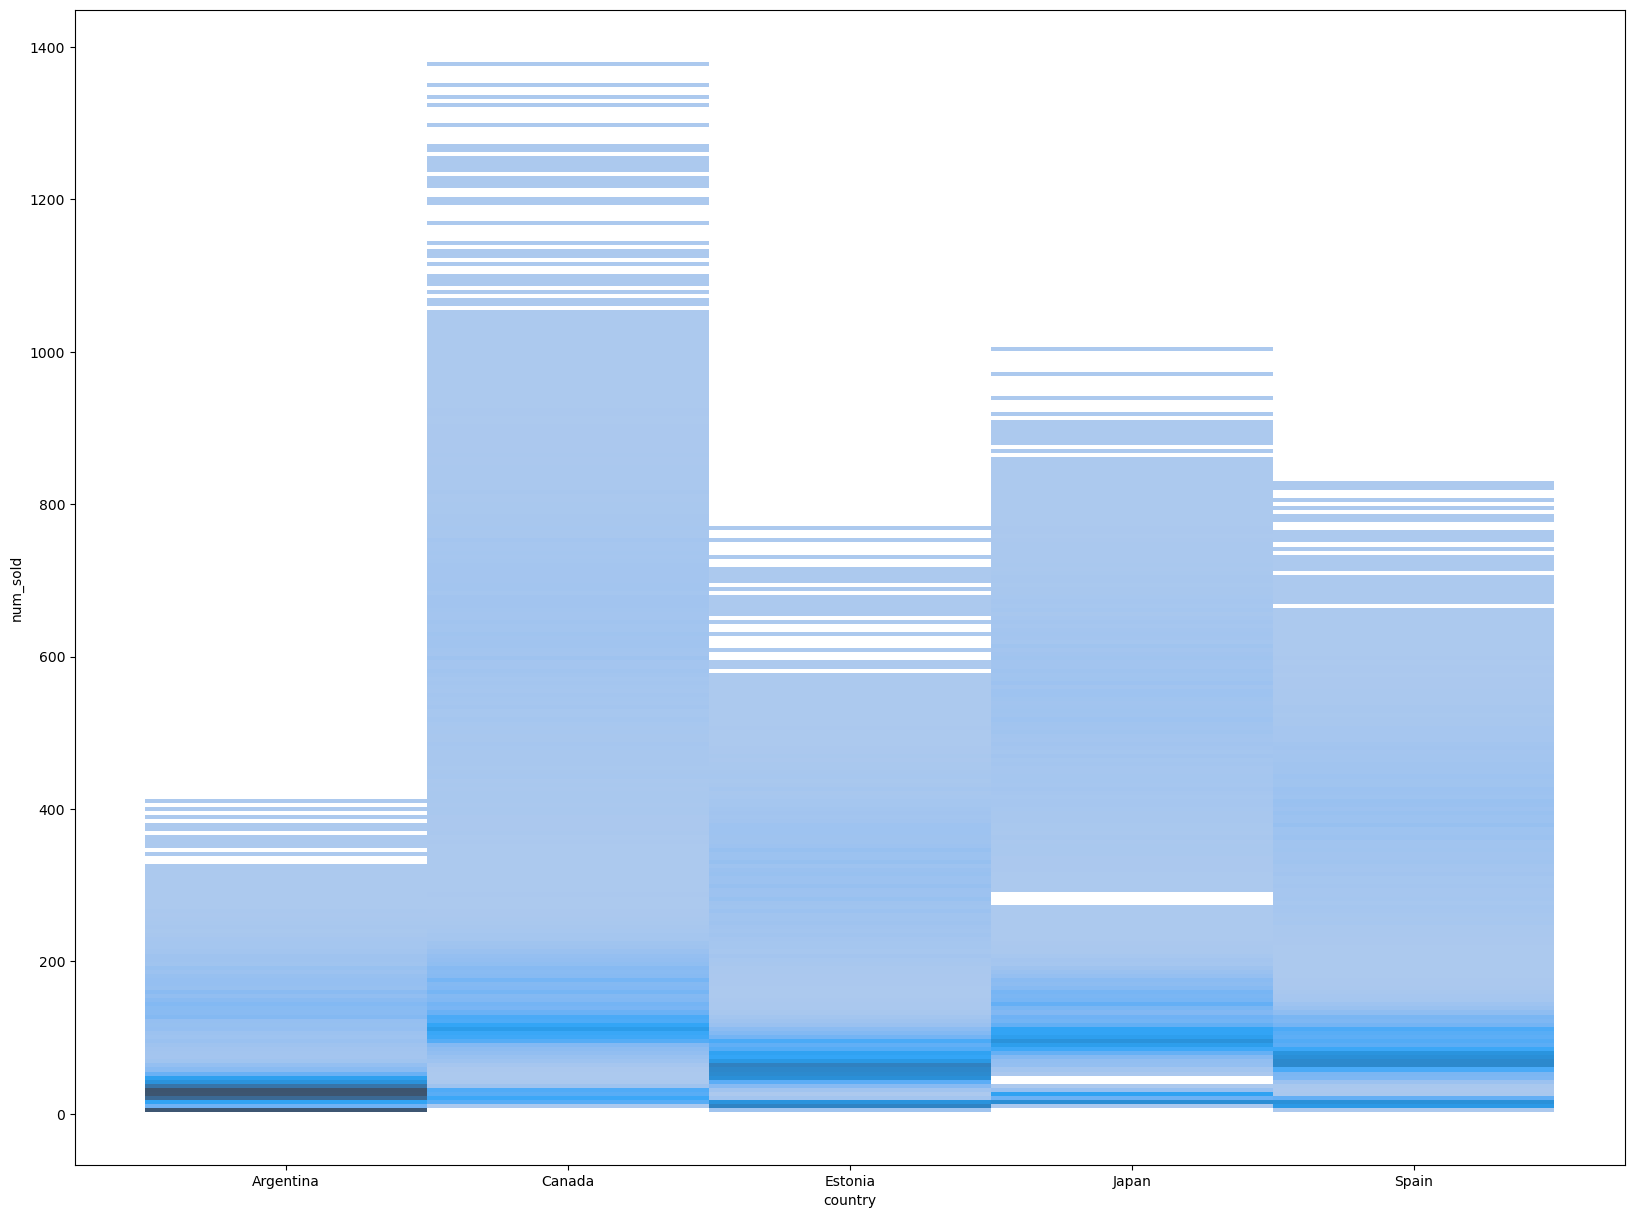

In [8]:
plt.figure(figsize = (20,15))
sns.histplot(data = df, x = 'country', y = 'num_sold')

_Больше всего продаж в Канаде_

In [9]:
df.groupby(['country', 'store'])['num_sold'].sum().sort_values(ascending = False)

country    store       
Canada     Kagglazon       4842322
Japan      Kagglazon       4154670
Spain      Kagglazon       3026408
Estonia    Kagglazon       2472309
Canada     Kaggle Store    1316665
Argentina  Kagglazon       1165626
Japan      Kaggle Store    1127598
Canada     Kaggle Learn     854127
Spain      Kaggle Store     821572
Japan      Kaggle Learn     731518
Estonia    Kaggle Store     670621
Spain      Kaggle Learn     532882
Estonia    Kaggle Learn     434389
Argentina  Kaggle Store     314600
           Kaggle Learn     203018
Name: num_sold, dtype: int64

In [10]:
pd.pivot_table(data = df, index=['year', 'month'],
               columns='store',
               values='num_sold').style.background_gradient('Dark2')

_Самые популярными месяцами являются ***декабрь*** и ***январь***(На новогодние праздники)_

_Наиболее популярный магазин **Kagglazone**_

In [11]:
holidays.CountryHoliday('AR', years=2017)

{datetime.date(2017, 1, 1): 'Año Nuevo', datetime.date(2017, 2, 27): 'Día de Carnaval', datetime.date(2017, 2, 28): 'Día de Carnaval', datetime.date(2017, 3, 24): 'Día Nacional de la Memoria por la Verdad y la Justicia', datetime.date(2017, 4, 2): 'Día del Veterano y de los Caidos en la Guerra de Malvinas', datetime.date(2017, 4, 14): 'Viernes Santo', datetime.date(2017, 5, 1): 'Día del Trabajo', datetime.date(2017, 5, 25): 'Día de la Revolución de Mayo', datetime.date(2017, 6, 20): 'Paso a la Inmortalidad del General Don Manuel Belgrano', datetime.date(2017, 7, 9): 'Día de la Independencia', datetime.date(2017, 12, 8): 'Inmaculada Concepción de María', datetime.date(2017, 12, 25): 'Navidad', datetime.date(2017, 6, 17): 'Paso a la Inmortalidad del General Don Martín Miguel de Güemes', datetime.date(2017, 8, 21): 'Paso a la Inmortalidad del General Don José de San Martin (Observado)', datetime.date(2017, 10, 16): 'Día del Respeto a la Diversidad Cultural (Observado)', datetime.date(2017

In [12]:
years_list = [2017,2018,2019,2020,2021]

holidays_arg = holidays.CountryHoliday('AR', years=years_list)
holidays_can = holidays.CountryHoliday('CA', years = years_list)
holidays_est = holidays.CountryHoliday('EE', years = years_list)
holidays_jap = holidays.CountryHoliday('JP', years=years_list)
holidays_spn = holidays.CountryHoliday('ES', years=years_list)

df_holidays = pd.DataFrame(columns=['date', 'AR', 'CA', 'EE', 'JP', 'ES'])

for date in pd.date_range(start='2017-01-01', end='2021-12-31'):
    ar = 1 if date in holidays_arg else 0
    ca = 1 if date in holidays_can else 0
    ee = 1 if date in holidays_est else 0
    jp = 1 if date in holidays_jap else 0
    es = 1 if date in holidays_spn else 0
    df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
    
df['Arg_holiday'] = df['date'].map(df_holidays.set_index('date')['AR']).astype(int)
df['Can_holiday'] = df['date'].map(df_holidays.set_index('date')['CA']).astype(int)
df['Est_holiday'] = df['date'].map(df_holidays.set_index('date')['EE']).astype(int)
df['Jap_holiday'] = df['date'].map(df_holidays.set_index('date')['JP']).astype(int)
df['Sp_holiday'] = df['date'].map(df_holidays.set_index('date')['ES']).astype(int)

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipyke

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipyke

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipyke

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipyke

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipyke

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipyke

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipyke

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipyke

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipyke

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipyke

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipyke

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipyke

C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_2648\923405114.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays = df_holidays.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)
C:\Users\Kirill\AppData\Local\Temp\ipyke

In [13]:
df

,id,date,country,store,product,num_sold,year,month,day,weekday,Arg_holiday,Can_holiday,Est_holiday,Jap_holiday,Sp_holiday
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,2017,1,1,6,1,1,1,1,0
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2017,1,1,6,1,1,1,1,0
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,2017,1,1,6,1,1,1,1,0
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,2017,1,1,6,1,1,1,1,0
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49,2017,1,1,6,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136945,136945,2021-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,700,2021,12,31,4,0,0,0,0,0
136946,136946,2021-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,752,2021,12,31,4,0,0,0,0,0
136947,136947,2021-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,111,2021,12,31,4,0,0,0,0,0
136948,136948,2021-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,641,2021,12,31,4,0,0,0,0,0


In [14]:
le = LabelEncoder()
df['countrys'] = le.fit_transform(df['country'])
df['stores'] = le.fit_transform(df['store'])
df['products'] = le.fit_transform(df['product'])

df_test['countrys'] = le.fit_transform(df_test['country'])
df_test['stores'] = le.fit_transform(df_test['store'])
df_test['products'] = le.fit_transform(df_test['product'])

NameError: name 'df_test' is not defined

In [ ]:
#c = pd.get_dummies(df['country'])
#df = pd.merge(df, c, left_index=True, right_index=True)
#s = pd.get_dummies(df['store'])
#df = pd.merge(df, s, left_index=True, right_index=True)
#p = pd.get_dummies(df['product'])
#df = pd.merge(df, p, left_index=True, right_index=True)

In [ ]:
df

### Test Ds

In [ ]:
df_test = pd.read_csv('test.csv')

In [ ]:
df_test

In [ ]:
hol_test = pd.DataFrame(columns=['date', 'AR', 'CA', 'EE', 'JP', 'ES'])

In [ ]:
df_test['date'] = df_test['date'].astype('datetime64')

In [ ]:
df_test['year']= df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month
df_test['day'] = df_test['date'].dt.day
df_test['weekday'] = df_test['date'].dt.dayofweek

In [ ]:
arg_h = holidays.CountryHoliday("AR", years=2022)
can_h = holidays.CountryHoliday("CA", years=2022)
est_h = holidays.CountryHoliday("EE", years=2022)
jap_h = holidays.CountryHoliday("JP", years=2022)
spa_h = holidays.CountryHoliday("ES", years=2022)

In [ ]:
for date in pd.date_range(start = '2022-01-01', end='2022-12-31'):
    ar = 1 if date in arg_h else 0
    ca = 1 if date in can_h else 0
    ee = 1 if date in est_h else 0
    jp = 1 if date in jap_h else 0
    es = 1 if date in spa_h else 0
    hol_test = hol_test.append({'date': date, 'AR': ar, 'CA': ca, 'EE': ee, 'JP': jp, 'ES': es}, ignore_index=True)

In [ ]:
df_test['Arg_holiday'] = df_test['date'].map(hol_test.set_index('date')['AR']).astype(int)
df_test['Can_holiday'] = df_test['date'].map(hol_test.set_index('date')['CA']).astype(int)
df_test['Est_holiday'] = df_test['date'].map(hol_test.set_index('date')['EE']).astype(int)
df_test['Jap_holiday'] = df_test['date'].map(hol_test.set_index('date')['JP']).astype(int)
df_test['Sp_holiday'] = df_test['date'].map(hol_test.set_index('date')['ES']).astype(int)

In [ ]:
df_test['countrys'] = le.fit_transform(df_test['country'])
df_test['stores'] = le.fit_transform(df_test['store'])
df_test['products'] = le.fit_transform(df_test['product'])

In [15]:
#s = pd.get_dummies(df_test['country'])
#df_test = pd.merge(df_test, s, left_index=True, right_index=True)
#s = pd.get_dummies(df_test['store'])
#df_test = pd.merge(df_test, s, left_index=True, right_index=True)
#s = pd.get_dummies(df_test['product'])
#df_test = pd.merge(df_test, s, left_index=True, right_index=True)

**Разделение на трейн и тест выборки**

In [16]:
def smape(act, pred):
    return round(
        np.mean(
            np.abs(pred - act) / 
            ((np.abs(pred) + np.abs(act))/2)
        )*100, 2
    )

In [17]:
df.groupby('date')['num_sold'].sum()

date
2017-01-01    20086
2017-01-02    15563
2017-01-03    15039
2017-01-04    14516
2017-01-05    14083
              ...  
2021-12-27    16724
2021-12-28    18507
2021-12-29    20110
2021-12-30    20156
2021-12-31    20422
Name: num_sold, Length: 1826, dtype: int64

In [18]:
avg_sales_no_v = df[df['year'].isin((2019,2021))].groupby('month')['num_sold'].mean()
avg_sales_no_v

month
1     181.363656
2     173.638333
3     172.492258
4     169.591111
5     170.006022
6     164.365778
7     164.190323
8     164.676774
9     167.417556
10    170.206882
11    173.994222
12    189.582581
Name: num_sold, dtype: float64

In [19]:
avg_sales_virus = df[df['year'] == 2020].groupby('month')['num_sold'].mean()
avg_sales_virus

month
1     165.163871
2     161.590345
3     143.612043
4     114.600000
5     132.307957
6     140.437778
7     146.783226
8     148.123871
9     149.124889
10    153.098495
11    161.400444
12    170.059785
Name: num_sold, dtype: float64

In [20]:
ratios_for_months = avg_sales_no_v/avg_sales_virus

In [21]:
df.loc[df['year'] == 2020, 'num_sold'] *= df['month'].map(ratios_for_months)

<Axes: title={'center': 'Sales number distribution'}, xlabel='Year'>

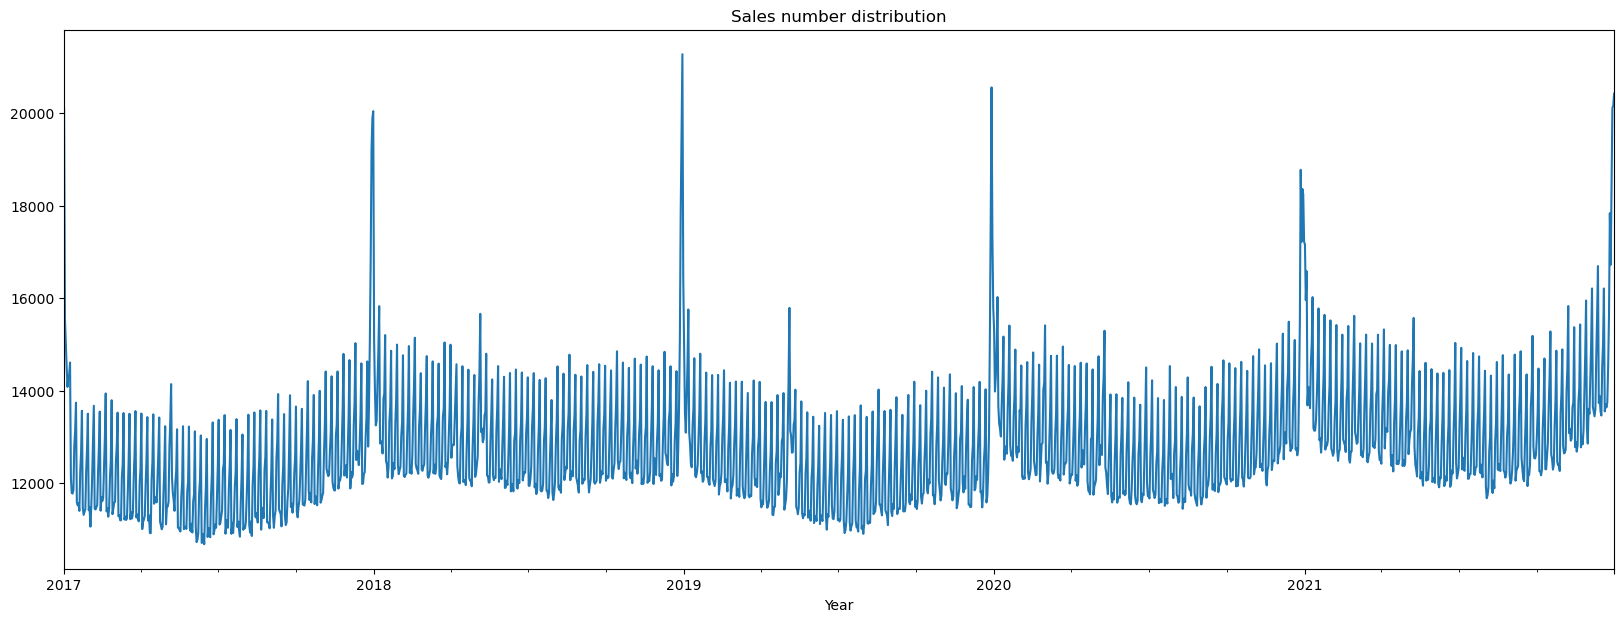

In [22]:
df.groupby('date')['num_sold'].sum().plot(kind='line', title='Sales number distribution', figsize=(20, 7), xlabel='Year')

In [23]:
X = df.drop(columns=['id', 'date', 'country', 'store', 'product', 'num_sold'])
y = df['num_sold']

validate_df = df_test.drop(columns=['id', 'date', 'country', 'store', 'product'])

NameError: name 'df_test' is not defined

In [24]:
df

,id,date,country,store,product,num_sold,year,month,day,weekday,Arg_holiday,Can_holiday,Est_holiday,Jap_holiday,Sp_holiday,countrys,stores,products
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63.0,2017,1,1,6,1,1,1,1,0,0,1,0
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66.0,2017,1,1,6,1,1,1,1,0,0,1,1
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9.0,2017,1,1,6,1,1,1,1,0,0,1,2
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59.0,2017,1,1,6,1,1,1,1,0,0,1,3
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49.0,2017,1,1,6,1,1,1,1,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136945,136945,2021-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,700.0,2021,12,31,4,0,0,0,0,0,4,0,0
136946,136946,2021-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,752.0,2021,12,31,4,0,0,0,0,0,4,0,1
136947,136947,2021-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,111.0,2021,12,31,4,0,0,0,0,0,4,0,2
136948,136948,2021-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,641.0,2021,12,31,4,0,0,0,0,0,4,0,3


In [25]:
df['day_sin'] = np.sin(2 * np.pi * df['day']/31)
df['day_cos'] = np.cos(2 * np.pi * df['day']/31)

df['dayofweek_sin'] = np.sin(2 * np.pi * df['weekday']/6) # indexed [0, 6]
df['dayofweek_cos'] = np.cos(2 * np.pi * df['weekday']/6)


df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

df_test['day_sin'] = np.sin(2 * np.pi * df_test['day']/31)
df_test['day_cos'] = np.cos(2 * np.pi * df_test['day']/31)

df_test['dayofweek_sin'] = np.sin(2 * np.pi * df_test['weekday']/6) # indexed [0, 6]
df_test['dayofweek_cos'] = np.cos(2 * np.pi * df_test['weekday']/6)


df_test['month_sin'] = np.sin(2 * np.pi * df_test['month']/12)
df_test['month_cos'] = np.cos(2 * np.pi * df_test['month']/12)

NameError: name 'df_test' is not defined

In [26]:
scaler = StandardScaler()
col = X.columns

X_train_scaler = scaler.fit_transform(X)
X_train_scaler = pd.DataFrame(X_train_scaler, columns=[col])

X_val_scaler = scaler.transform(validate_df)
X_val_scaler = pd.DataFrame(X_val_scaler, columns=[col])

NameError: name 'validate_df' is not defined

In [27]:
#X_train, X_test, y_train, y_test = train_test_split(X, y ,random_state=0, test_size=0.20)

***Попробую построить первую модель с помощью XGBoost***

**Пропустить данный участок**

In [41]:
#pip install xgboost

In [42]:
#gs_params = {'max_depth': [3,5,7,9], 'gamma':[0,2,3], 'min_child_weight':[1,2,4], 'n_estimators': range(50,300,50),
#            'learning_rate': [0.001, 0.01, 0.5], 'random_state':[0]}

In [43]:
xgb = XGBRegressor()
#gs = GridSearchCV(xgb, param_grid=gs_params, cv=5)

In [44]:
xgb.set_params

<bound method XGBModel.set_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)>

In [45]:
#gridd = gs.fit(X_train, y_train)

In [46]:
#gridd.best_params_

In [47]:
xgb = XGBRegressor(gamma=1, max_depth =7,learning_rate = 0.01,
                   n_estimators = 250, random_state = 0, n_jobs =-1)

In [48]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [49]:
pred = xgb.predict(X_train)

In [51]:
mean_absolute_error(y_train, pred)

19.40258564094543

In [52]:
mean_squared_error(y_train, pred)

1352.8874065326868

In [53]:
xgb_2 = XGBRegressor(gamma = 0, learning_rate = 0.5,
                     max_depth = 7, min_child_weight = 1, n_estimators = 250, random_state = 0)

In [54]:
xgb_2.fit(X_train, y_train)

predict_2 = xgb_2.predict(X_train)
print(mean_absolute_error(y_train, predict_2))
print(mean_squared_error(y_train, predict_2))

6.170136589674545
108.84654423758889


In [55]:
predict_test = xgb_2.predict(X_test)
print(mean_absolute_error(y_test, predict_test))
print(mean_squared_error(y_test, predict_test))

8.14574910812402
207.78913814099292


In [56]:
y_test

78189     61
82486     96
58131     40
97970    165
82041    182
        ... 
66217     20
95897     14
79417     18
51227      4
8241     109
Name: num_sold, Length: 34238, dtype: int64

In [57]:
predict_test_1 = xgb.predict(X_test)
print(mean_absolute_error(y_test, predict_test_1))
print(mean_squared_error(y_test, predict_test_1))

19.363554310684442
1327.9591887951074


In [59]:
smape(y_train, predict_2)

5.64

In [60]:
smape(y_test, predict_test_1)

11.49

In [61]:
np.round(predict_test_1)

array([71., 74., 36., ..., 16.,  4., 99.], dtype=float32)

In [62]:
X_train

,year,month,day,weekday,Arg_holiday,Can_holiday,Est_holiday,Jap_holiday,Sp_holiday,Argentina,...,Japan,Spain,Kagglazon,Kaggle Learn,Kaggle Store,Using LLMs to Improve Your Coding,Using LLMs to Train More LLMs,Using LLMs to Win Friends and Influence People,Using LLMs to Win More Kaggle Competitions,Using LLMs to Write Better
0,0.001294,-0.443335,-1.557812,0.002941,-0.229590,-0.185759,-0.182138,4.282888,-0.166913,-0.499203,...,-0.500253,2.000024,-0.708140,-0.706265,1.414596,-0.500389,-0.499264,-0.499644,-0.501043,2.001364
1,0.001294,-0.443335,-0.762209,0.002941,-0.229590,-0.185759,-0.182138,-0.233487,-0.166913,-0.499203,...,-0.500253,2.000024,-0.708140,1.415898,-0.706916,-0.500389,-0.499264,-0.499644,1.995835,-0.499659
2,0.708502,1.004647,-0.648551,1.003323,-0.229590,-0.185759,-0.182138,-0.233487,-0.166913,2.003194,...,-0.500253,-0.499994,-0.708140,1.415898,-0.706916,-0.500389,-0.499264,2.001425,-0.501043,-0.499659
3,1.415709,1.004647,1.283627,-0.497250,-0.229590,-0.185759,-0.182138,-0.233487,-0.166913,2.003194,...,-0.500253,-0.499994,-0.708140,-0.706265,1.414596,-0.500389,-0.499264,-0.499644,1.995835,-0.499659
4,0.001294,1.004647,-0.421236,1.003323,4.355597,-0.185759,-0.182138,-0.233487,5.991133,-0.499203,...,-0.500253,-0.499994,-0.708140,-0.706265,1.414596,-0.500389,-0.499264,2.001425,-0.501043,-0.499659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102707,-0.705913,0.135858,-0.193921,1.003323,-0.229590,-0.185759,-0.182138,-0.233487,-0.166913,-0.499203,...,-0.500253,2.000024,-0.708140,-0.706265,1.414596,-0.500389,-0.499264,-0.499644,1.995835,-0.499659
102708,0.708502,0.135858,1.056312,1.003323,-0.229590,-0.185759,-0.182138,-0.233487,-0.166913,-0.499203,...,-0.500253,2.000024,-0.708140,1.415898,-0.706916,-0.500389,-0.499264,-0.499644,-0.501043,2.001364
102709,0.708502,0.135858,-1.444154,0.503132,-0.229590,-0.185759,-0.182138,-0.233487,-0.166913,2.003194,...,-0.500253,-0.499994,1.412151,-0.706265,-0.706916,-0.500389,-0.499264,-0.499644,-0.501043,2.001364
102710,1.415709,-0.732932,0.715339,0.002941,-0.229590,-0.185759,-0.182138,-0.233487,-0.166913,-0.499203,...,1.998990,-0.499994,-0.708140,-0.706265,1.414596,-0.500389,-0.499264,2.001425,-0.501043,-0.499659


**Работа с тестовыми данными**

In [63]:
df_test.head()

,id,date,country,store,product,year,month,day,weekday,Arg_holiday,...,Japan,Spain,Kagglazon,Kaggle Learn,Kaggle Store,Using LLMs to Improve Your Coding,Using LLMs to Train More LLMs,Using LLMs to Win Friends and Influence People,Using LLMs to Win More Kaggle Competitions,Using LLMs to Write Better
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,5,1,...,0,0,0,1,0,1,0,0,0,0
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,5,1,...,0,0,0,1,0,0,1,0,0,0
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,5,1,...,0,0,0,1,0,0,0,1,0,0
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,5,1,...,0,0,0,1,0,0,0,0,1,0
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,5,1,...,0,0,0,1,0,0,0,0,0,1


In [118]:
df_test['day_sin'] = np.sin(2*np.pi*df_test['day']/31)
df_test['day_cos'] = np.cos(2*np.pi*df_test['day']/31)

df_test['month_sin'] = np.sin(2*np.pi*df_test['month']/12)
df_test['month_cos'] = np.cos(2*np.pi*df_test['month']/12)

In [112]:
df_test.drop(columns=['id', 'date', 'country', 'store', 'product'], inplace = True)

In [139]:
df_test
col_test = df_test.columns

In [140]:
df_test

,year,month,day,weekday,Arg_holiday,Can_holiday,Est_holiday,Jap_holiday,Sp_holiday,Argentina,...,Japan,Spain,Kagglazon,Kaggle Learn,Kaggle Store,Using LLMs to Improve Your Coding,Using LLMs to Train More LLMs,Using LLMs to Win Friends and Influence People,Using LLMs to Win More Kaggle Competitions,Using LLMs to Write Better
0,2022,1,1,5,1,1,1,1,1,1,...,0,0,0,1,0,1,0,0,0,0
1,2022,1,1,5,1,1,1,1,1,1,...,0,0,0,1,0,0,1,0,0,0
2,2022,1,1,5,1,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
3,2022,1,1,5,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,1,0
4,2022,1,1,5,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,2022,12,31,5,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
27371,2022,12,31,5,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0
27372,2022,12,31,5,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
27373,2022,12,31,5,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0


In [67]:
X_val = scaler.transform(df_test)

In [68]:
df_test = pd.DataFrame(X_val, columns=col)

In [69]:
df_test ### Валидационные данные

,year,month,day,weekday,Arg_holiday,Can_holiday,Est_holiday,Jap_holiday,Sp_holiday,Argentina,...,Japan,Spain,Kagglazon,Kaggle Learn,Kaggle Store,Using LLMs to Improve Your Coding,Using LLMs to Train More LLMs,Using LLMs to Win Friends and Influence People,Using LLMs to Win More Kaggle Competitions,Using LLMs to Write Better
0,2.122916,-1.601721,-1.671469,1.003323,4.355597,5.383322,5.490330,4.282888,5.991133,2.003194,...,-0.500253,-0.499994,-0.708140,1.415898,-0.706916,1.998444,-0.499264,-0.499644,-0.501043,-0.499659
1,2.122916,-1.601721,-1.671469,1.003323,4.355597,5.383322,5.490330,4.282888,5.991133,2.003194,...,-0.500253,-0.499994,-0.708140,1.415898,-0.706916,-0.500389,2.002950,-0.499644,-0.501043,-0.499659
2,2.122916,-1.601721,-1.671469,1.003323,4.355597,5.383322,5.490330,4.282888,5.991133,2.003194,...,-0.500253,-0.499994,-0.708140,1.415898,-0.706916,-0.500389,-0.499264,2.001425,-0.501043,-0.499659
3,2.122916,-1.601721,-1.671469,1.003323,4.355597,5.383322,5.490330,4.282888,5.991133,2.003194,...,-0.500253,-0.499994,-0.708140,1.415898,-0.706916,-0.500389,-0.499264,-0.499644,1.995835,-0.499659
4,2.122916,-1.601721,-1.671469,1.003323,4.355597,5.383322,5.490330,4.282888,5.991133,2.003194,...,-0.500253,-0.499994,-0.708140,1.415898,-0.706916,-0.500389,-0.499264,-0.499644,-0.501043,2.001364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,2.122916,1.583840,1.738257,1.003323,-0.229590,-0.185759,-0.182138,-0.233487,-0.166913,-0.499203,...,-0.500253,2.000024,1.412151,-0.706265,-0.706916,1.998444,-0.499264,-0.499644,-0.501043,-0.499659
27371,2.122916,1.583840,1.738257,1.003323,-0.229590,-0.185759,-0.182138,-0.233487,-0.166913,-0.499203,...,-0.500253,2.000024,1.412151,-0.706265,-0.706916,-0.500389,2.002950,-0.499644,-0.501043,-0.499659
27372,2.122916,1.583840,1.738257,1.003323,-0.229590,-0.185759,-0.182138,-0.233487,-0.166913,-0.499203,...,-0.500253,2.000024,1.412151,-0.706265,-0.706916,-0.500389,-0.499264,2.001425,-0.501043,-0.499659
27373,2.122916,1.583840,1.738257,1.003323,-0.229590,-0.185759,-0.182138,-0.233487,-0.166913,-0.499203,...,-0.500253,2.000024,1.412151,-0.706265,-0.706916,-0.500389,-0.499264,-0.499644,1.995835,-0.499659


***Новая модель***

In [70]:
xgb_2.set_params

<bound method XGBModel.set_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)>

In [71]:
xgb_3 = XGBRegressor(gamma = 1, max_depth = 8, learning_rate = 0.5, n_estimators = 250, random_state = 0)

In [72]:
xgb_3.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [73]:
xgb_3_train = xgb_3.predict(X_train)
xgb_3_test = xgb_3.predict(X_test)

print('MAE: {0} | MSE: {1} | Train_SMAPE: {2} | Test_SMAPE: {3}'.format(np.round(mean_absolute_error(y_test, xgb_3_test),2),
                                                                       np.round(mean_squared_error(y_test, xgb_3_test), 2),
                                                                       smape(y_train, xgb_3_train),
                                                                       smape(y_test, xgb_3_test)))

MAE: 8.43 | MSE: 227.16 | Train_SMAPE: 4.66 | Test_SMAPE: 6.76


In [74]:
for i in np.arange(150,300, 50):
    xgb_4 = XGBRegressor(gamma = 1, max_depth = 8, learning_rate = 0.1, n_estimators = i, random_state = 0)

    xgb_4.fit(X_train, y_train)
    xgb_4_train = xgb_4.predict(X_train)
    xgb_4_test = xgb_4.predict(X_test)

    print(i, 'MAE: {0} | MSE: {1} | Train_SMAPE: {2} | Test_SMAPE: {3}'.format(np.round(mean_absolute_error(y_test, xgb_4_test),2),
                                                                           np.round(mean_squared_error(y_test, xgb_4_test), 2),
                                                                           smape(y_train, xgb_4_train),
                                                                           smape(y_test, xgb_4_test)))

150 MAE: 7.55 | MSE: 192.61 | Train_SMAPE: 4.95 | Test_SMAPE: 5.31
200 MAE: 7.46 | MSE: 187.85 | Train_SMAPE: 4.77 | Test_SMAPE: 5.23
250 MAE: 7.42 | MSE: 186.05 | Train_SMAPE: 4.66 | Test_SMAPE: 5.21


### Выше интересно

In [105]:
for i in np.arange(1500,2000, 100):
    xgb_4 = XGBRegressor(gamma = 1, max_depth = 8, learning_rate = 0.01, n_estimators = i, random_state = 0)

    xgb_4.fit(X_train, y_train)
    xgb_4_train = xgb_4.predict(X_train)
    xgb_4_test = xgb_4.predict(X_test)

    print(i, 'MAE: {0} | MSE: {1} | Train_SMAPE: {2} | Test_SMAPE: {3}'.format(np.round(mean_absolute_error(y_test, xgb_4_test),2),
                                                                           np.round(mean_squared_error(y_test, xgb_4_test), 2),
                                                                           smape(y_train, xgb_4_train),
                                                                           smape(y_test, xgb_4_test)))

1500 MAE: 7.62 | MSE: 198.13 | Train_SMAPE: 4.9 | Test_SMAPE: 5.28
1600 MAE: 7.59 | MSE: 196.34 | Train_SMAPE: 4.86 | Test_SMAPE: 5.26
1700 MAE: 7.55 | MSE: 194.65 | Train_SMAPE: 4.83 | Test_SMAPE: 5.24
1800 MAE: 7.52 | MSE: 192.81 | Train_SMAPE: 4.78 | Test_SMAPE: 5.22
1900 MAE: 7.49 | MSE: 191.52 | Train_SMAPE: 4.75 | Test_SMAPE: 5.2


### Выше интересно

In [76]:
xgb_5 = XGBRegressor(gamma = 1, max_depth = 8, learning_rate = 0.01, n_estimators = 1900, random_state = 0)
xgb_5.fit(X_train, y_train)
pred_xgb_5 = xgb_5.predict(X_train)

In [77]:
pred_val_xgb_5 = xgb_5.predict(X_val)
r_val_5 = np.round(pred_val_xgb_5).astype(int)

In [78]:
xgb_6 = XGBRegressor(gamma = 1, max_depth = 8, learning_rate = 0.1, n_estimators = 250, random_state = 0)
xgb_6.fit(X_train,y_train)
pred_val_xgb_6 = xgb_6.predict(X_val)
r_val_6 = np.round(pred_val_xgb_6).astype(int)

In [116]:
from sklearn.model_selection import cross_val_score

cross_val_score(xgb_6, X, y)

array([0.97194321, 0.98466971, 0.98387148, 0.92455507, 0.92584383])

In [117]:
cross_val_score(xgb_5, X, y)

array([0.97217257, 0.98483597, 0.9823134 , 0.92654539, 0.92616805])

In [79]:
#r_val_5

In [80]:
#r_val_6

In [81]:
#val_predicted_mean_1 = np.round(np.mean( np.array([ r_val_5, r_val_6 ]), axis=0 )).astype(int)

In [82]:
#submission_3 = pd.DataFrame({'id': indexes_val, 'num_sold': val_predicted_mean_1})

In [83]:
#submission_3.to_csv('submission_3.csv', index=False)

In [84]:
#pd.read_csv('submission_3.csv')

In [186]:
samm = pd.read_csv('sample_submission.csv')
indexes_val = samm.id

In [86]:
#val_predict = xgb_3.predict(df_test)

In [ ]:
#val_predict = np.round(val_predict).astype(int)

In [ ]:
#subsample_2 = pd.DataFrame({'id':indexes_val, 'num_sold': val_predict})

**Predict on full data**

In [144]:
col_train = X.columns

scaler_X = scaler.fit_transform(X)
scaler_X_val = scaler.transform(df_test)

scaler_X = pd.DataFrame(scaler_X, columns=col_train)
scaler_X_val = pd.DataFrame(scaler_X_val, columns=col_train)

In [147]:
scaler_X.head()

,year,month,day,weekday,Arg_holiday,Can_holiday,Est_holiday,Jap_holiday,Sp_holiday,Argentina,...,Japan,Spain,Kagglazon,Kaggle Learn,Kaggle Store,Using LLMs to Improve Your Coding,Using LLMs to Train More LLMs,Using LLMs to Win Friends and Influence People,Using LLMs to Win More Kaggle Competitions,Using LLMs to Write Better
0,-1.414795,-1.60171,-1.673744,1.500548,4.366456,5.379073,5.42525,4.292497,-0.167789,2.0,...,-0.5,-0.5,-0.707107,1.414214,-0.707107,2.0,-0.5,-0.5,-0.5,-0.5
1,-1.414795,-1.60171,-1.673744,1.500548,4.366456,5.379073,5.42525,4.292497,-0.167789,2.0,...,-0.5,-0.5,-0.707107,1.414214,-0.707107,-0.5,2.0,-0.5,-0.5,-0.5
2,-1.414795,-1.60171,-1.673744,1.500548,4.366456,5.379073,5.42525,4.292497,-0.167789,2.0,...,-0.5,-0.5,-0.707107,1.414214,-0.707107,-0.5,-0.5,2.0,-0.5,-0.5
3,-1.414795,-1.60171,-1.673744,1.500548,4.366456,5.379073,5.42525,4.292497,-0.167789,2.0,...,-0.5,-0.5,-0.707107,1.414214,-0.707107,-0.5,-0.5,-0.5,2.0,-0.5
4,-1.414795,-1.60171,-1.673744,1.500548,4.366456,5.379073,5.42525,4.292497,-0.167789,2.0,...,-0.5,-0.5,-0.707107,1.414214,-0.707107,-0.5,-0.5,-0.5,-0.5,2.0


In [150]:
#xgb_5.fit(scaler_X, y)
#val_predict_5 = xgb_5.predict(scaler_X_val)

In [151]:
#val_predict_5

array([ 38.326763 ,  37.87519  ,   5.4408755, ..., 113.99803  ,
       662.3846   , 549.8273   ], dtype=float32)

In [152]:
#xgb_6.fit(scaler_X, y)
#val_predict_6 = xgb_6.predict(scaler_X_val)

In [153]:
#val_predict_6

array([ 39.873066 ,  38.091095 ,   4.5136013, ..., 116.012085 ,
       642.31256  , 529.759    ], dtype=float32)

In [154]:
#val_predicted_mean_2 = np.round(np.mean( np.array([ val_predict_5, val_predict_6]), axis=0 )).astype(int)
#val_predicted_mean_2

array([ 39,  38,   5, ..., 115, 652, 540])

In [159]:
#submission_4 = pd.DataFrame({'id': indexes_val, 'num_sold': val_predicted_mean_2})
#submission_4.to_csv("submission_4.csv", index = False)

In [160]:
val_predict_6

array([ 39.873066 ,  38.091095 ,   4.5136013, ..., 116.012085 ,
       642.31256  , 529.759    ], dtype=float32)

In [164]:
np.round(val_predict_5).astype(int)

array([ 38,  38,   5, ..., 114, 662, 550])

In [165]:
submission_5 = pd.DataFrame({'id': indexes_val, 'num_sold': np.round(val_predict_5).astype(int)})
submission_5.to_csv("submission_5.csv", index = False)

In [166]:
pd.read_csv('submission_5.csv')

,id,num_sold
0,136950,38
1,136951,38
2,136952,5
3,136953,34
4,136954,28
...,...,...
27370,164320,732
27371,164321,744
27372,164322,114
27373,164323,662


In [131]:
for i in np.arange(3,10):
    xgb_7 = XGBRegressor(max_depth = i, learning_rate = 0.01, n_estimators = 900, random_state = 0, reg_lambda = 1)

    xgb_7.fit(X_train, y_train)
    xgb_7_train = xgb_7.predict(X_train)
    xgb_7_test = xgb_7.predict(X_test)

    print(i, 'MAE: {0} | MSE: {1} | Train_SMAPE: {2} | Test_SMAPE: {3}'.format(np.round(mean_absolute_error(y_test, xgb_7_test),2),
                                                                           np.round(mean_squared_error(y_test, xgb_7_test), 2),
                                                                           smape(y_train, xgb_7_train),
                                                                           smape(y_test, xgb_7_test)))

3 MAE: 18.94 | MSE: 1084.8 | Train_SMAPE: 22.88 | Test_SMAPE: 23.49
4 MAE: 13.39 | MSE: 631.53 | Train_SMAPE: 13.96 | Test_SMAPE: 14.21
5 MAE: 10.98 | MSE: 429.17 | Train_SMAPE: 9.88 | Test_SMAPE: 10.0
6 MAE: 9.67 | MSE: 323.48 | Train_SMAPE: 7.7 | Test_SMAPE: 7.8
7 MAE: 8.65 | MSE: 256.4 | Train_SMAPE: 6.39 | Test_SMAPE: 6.59
8 MAE: 8.0 | MSE: 222.79 | Train_SMAPE: 5.33 | Test_SMAPE: 5.6
9 MAE: 7.69 | MSE: 207.91 | Train_SMAPE: 4.64 | Test_SMAPE: 5.03


In [132]:
xgb_base = XGBRegressor()

In [136]:
gs_params = {'max_depth': [3,10],
             'n_estimators': range(500,1000,100),
             'learning_rate': [0.01,0.02,0.03,0.04, 0.05],
             'random_state':[0],
             'reg_lambda': [1,2,3]}

gs = GridSearchCV(xgb_base, param_grid=gs_params, scoring='neg_mean_squared_error', cv = 3)
searched = gs.fit(X_train, y_train)

In [138]:
gs.best_params_

{'learning_rate': 0.03,
 'max_depth': 10,
 'n_estimators': 600,
 'random_state': 0,
 'reg_lambda': 3}

In [140]:
model = gs.best_estimator_

In [141]:
model.fit(X_train, y_train)
model_train = model.predict(X_train)
model_test = model.predict(X_test)

print(i, 'MAE: {0} | MSE: {1} | Train_SMAPE: {2} | Test_SMAPE: {3}'.format(np.round(mean_absolute_error(y_test, model_test),2),
                                                                               np.round(mean_squared_error(y_test, model_test), 2),
                                                                               smape(y_train, model_train),
                                                                               smape(y_test, model_test)))

9 MAE: 7.35 | MSE: 192.17 | Train_SMAPE: 3.8 | Test_SMAPE: 4.79


In [145]:
val_predict_6 = model.predict(df_test)
submission_6 = pd.DataFrame({'id': indexes_val, 'num_sold': np.round(val_predict_6).astype(int)})
submission_6.to_csv("submission_6.csv", index = False)

**Продолжил здесь**

In [173]:
model_xgb = XGBRegressor(max_depth=10, learning_rate=0.03, n_estimators=250, random_state=0, reg_lambda=7, gamma=1)

In [178]:
kfold_5_predict = []
indexes_train_kf = []
indexes_test_kf = []
val_predictions = []

kf = KFold(n_splits=5, random_state=0, shuffle=True)

for kf_train, kf_test in kf.split(X_train_scaler):
    model_xgb.fit(X_train_scaler.iloc[kf_train], y[kf_train])
    predict_train = model_xgb.predict(X_train_scaler.iloc[kf_train])
    predict_test = model_xgb.predict(X_train_scaler.iloc[kf_test])
    kfold_5_predict.append(np.round(predict))
    indexes_train_kf.append(kf_train)
    indexes_test_kf.append(kf_test)
    print('Train_SMAPE: {0} | Test_SMAPE: {1}'.format(smape(y[kf_train], predict_train), smape(y[kf_test], predict_test)))
    val_predict = model_xgb.predict(X_val_scaler)
    val_predictions.append(val_predict)

Train_SMAPE: 4.71 | Test_SMAPE: 5.08
Train_SMAPE: 4.73 | Test_SMAPE: 5.13
Train_SMAPE: 4.72 | Test_SMAPE: 5.1
Train_SMAPE: 4.73 | Test_SMAPE: 5.07
Train_SMAPE: 4.69 | Test_SMAPE: 5.06


In [180]:
np.round(val_predictions)

array([[ 34.,  36.,   5., ..., 118., 627., 529.],
       [ 36.,  37.,   7., ..., 132., 631., 537.],
       [ 34.,  35.,   6., ..., 119., 640., 540.],
       [ 36.,  37.,   5., ..., 129., 631., 541.],
       [ 35.,  36.,   6., ..., 116., 632., 556.]], dtype=float32)

**Плохие ответы**

In [109]:
kfold_5_predict[0]

array([ 71.,  72., 296., ..., 121., 157., 544.], dtype=float32)

In [186]:
X = pd.merge(X, y, left_index=True, right_index=True)

In [159]:
X_droped_year = X.drop('year', axis = 1)
validate_df_year_drop = validate_df.drop('year', axis = 1)

In [103]:
X = df.drop(['id', 'date', 'country', 'store', 'product', 'num_sold', 'month', 'day', 'weekday'], axis = 1)
y = df['num_sold']

X_val = df_test.drop(['id', 'date', 'country', 'store', 'product', 'month', 'day', 'weekday'], axis = 1)

In [108]:
coll = X.columns


scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)

X = pd.DataFrame(X, columns=[coll])
X_val = pd.DataFrame(X_val, columns=[coll])

In [213]:
model_xgb = XGBRegressor(max_depth = 9, learning_rate = 0.1, n_estimators = 1500, random_state = 0, gamma = 1, reg_lambda=5)

In [214]:
kfold_5_predict = []
indexes_train_kf = []
indexes_test_kf = []
val_predictions = []

kf = KFold(n_splits=5, random_state=0, shuffle=True)

for kf_train, kf_test in kf.split(X):
    model_xgb.fit(X.iloc[kf_train], y[kf_train])
    predict_train = model_xgb.predict(X.iloc[kf_train])
    predict_test = model_xgb.predict(X.iloc[kf_test])
    kfold_5_predict.append(np.round(predict_test))
    indexes_train_kf.append(kf_train)
    indexes_test_kf.append(kf_test)
    print('Train_SMAPE: {0} | Test_SMAPE: {1}'.format(smape(y[kf_train], np.round(predict_train)),
                                                      smape(y[kf_test], np.round(predict_test))))
    val_predict = model_xgb.predict(X_val)
    val_predictions.append(val_predict)

Train_SMAPE: 4.19 | Test_SMAPE: 7.09
Train_SMAPE: 4.21 | Test_SMAPE: 7.19
Train_SMAPE: 4.19 | Test_SMAPE: 7.04
Train_SMAPE: 4.19 | Test_SMAPE: 7.02
Train_SMAPE: 4.21 | Test_SMAPE: 7.11


In [223]:
min(np.round(val_predictions[0]))

-4.0

In [224]:
best_hyperparams = {'iterations': 282, 'learning_rate': 0.09783414836979615, 'depth': 10, 'l2_leaf_reg': 6.888098846099011, 'early_stopping_rounds': 12}

In [235]:
model = CatBoostRegressor(**best_hyperparams)

model.fit(X, y, verbose=False)

pred_val_catboost = model.predict(X_val)


In [31]:
y

0          63.0
1          66.0
2           9.0
3          59.0
4          49.0
          ...  
136945    700.0
136946    752.0
136947    111.0
136948    641.0
136949    539.0
Name: num_sold, Length: 136950, dtype: float64